In [1]:
import sys
# enable importing the modules from probcalkge
sys.path.append('../')
sys.path.append('../probcalkge')

In [2]:
from pprint import pprint
from copy import deepcopy
from typing import Iterable, Callable, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit

In [3]:
from probcalkge import Experiment, ExperimentResult
from probcalkge import get_calibrators
from probcalkge import get_datasets,  get_kgemodels
from probcalkge import brier_score, negative_log_loss, ks_error, ece, cal_curve

In [4]:
from probcalkge.calmodels2 import get_calibrators
ds = get_datasets()
cals = get_calibrators()
kges = get_kgemodels()

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [5]:
exp = Experiment(
    cals=[cals.uncal, cals.platt, cals.isot, cals.beta, cals.histbin], 
    datasets=[ds.fb13, ds.wn18, ds.yago39, ds.dp50, ds.nations, ds.kinship, ds.umls], 
    kges=[kges.transE, kges.complEx, kges.distMult, kges.hoLE], 
    metrics=[brier_score, negative_log_loss, ks_error, ece]
    )

In [6]:
exp.load_trained_kges('../saved_models/')

Loaded models:
{'DBpedia50': {'ComplEx': <ampligraph.latent_features.models.ComplEx.ComplEx object at 0x0000015AE42DB508>,
               'DistMult': <ampligraph.latent_features.models.DistMult.DistMult object at 0x0000015A8048EFC8>,
               'HolE': <ampligraph.latent_features.models.HolE.HolE object at 0x0000015A809C5F88>,
               'TransE': <ampligraph.latent_features.models.TransE.TransE object at 0x0000015A8053C048>},
 'DBpedia_ET': OrderedDict([('ComplEx',
                             <ampligraph.latent_features.models.ComplEx.ComplEx object at 0x0000015A80579048>),
                            ('DistMult',
                             <ampligraph.latent_features.models.DistMult.DistMult object at 0x0000015A80FD6D08>),
                            ('TransE',
                             <ampligraph.latent_features.models.TransE.TransE object at 0x0000015A874C2048>)]),
 'FB13k': {'ComplEx': <ampligraph.latent_features.models.ComplEx.ComplEx object at 0x0000015A8053C248>,

In [7]:
exp_res = exp.run_with_trained_kges()

training various calibrators for TransE on FB13k ...
training various calibrators for ComplEx on FB13k ...
training various calibrators for DistMult on FB13k ...
training various calibrators for HolE on FB13k ...
training various calibrators for TransE on WN11 ...
training various calibrators for ComplEx on WN11 ...
training various calibrators for DistMult on WN11 ...
training various calibrators for HolE on WN11 ...
training various calibrators for TransE on YAGO39 ...
training various calibrators for ComplEx on YAGO39 ...
training various calibrators for DistMult on YAGO39 ...
training various calibrators for HolE on YAGO39 ...
training various calibrators for TransE on DBpedia50 ...
training various calibrators for ComplEx on DBpedia50 ...
training various calibrators for DistMult on DBpedia50 ...
training various calibrators for HolE on DBpedia50 ...
training various calibrators for TransE on Nations ...
training various calibrators for ComplEx on Nations ...
training various cali

In [8]:
from sklearn.calibration import CalibrationDisplay

plt.rcParams['figure.dpi'] = 200 # default for me was 75
plt.rc('axes', labelsize=3)
plt.rc('axes', titlesize=3)
plt.rc('xtick', labelsize=3)
plt.rc('ytick', labelsize=3)
plt.rc('legend', fontsize=3)
plt.rc('lines', linewidth=0.5)
plt.rc('lines', markersize=0.5)


def plot_ds_kge_cals(data, kge, cals, ax=None):
    ax = plt.axes() if ax == None else ax

    for cal in cals:
        scores = kge.predict(data.X_test)
        probs = cal.predict(expit(scores))
        CalibrationDisplay.from_predictions(data.y_test, probs, ax=ax, name=cal.name)
    
    ax.set_title(f'{data.name}-{kge.name}')
    ax.legend()
    ax.get_legend().remove()
    ax.set(xlabel=None)
    ax.set(ylabel=None)
        

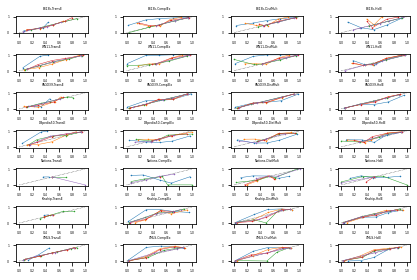

In [9]:
fig, axes = plt.subplots(7, 4)
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
fig.tight_layout(h_pad=0.8)
for i, data in enumerate(exp.datasets):
    for j, kge in enumerate(exp.trained_kges[data.name].values()):
        cals = exp.trained_cals[data.name][kge.name].values()
        plot_ds_kge_cals(data, kge, cals, axes[i][j])

# plt.legend()

In [10]:
from sklearn.metrics import accuracy_score

res = {}
for i, data in enumerate(exp.datasets):
    res[data.name] = {}
    for j, kge in enumerate(exp.trained_kges[data.name].values()):
        res[data.name][kge.name] = []
        for cal in  exp.trained_cals[data.name][kge.name].values():
            scores = kge.predict(data.X_test)
            probs = cal.predict(expit(scores))
            # if cal.name == 'UncalCalibrator':
            #     print(probs) 
            preds = probs > 0.5
            print(f'{data.name}-{kge.name}-{cal.name}   {accuracy_score(data.y_test, preds)}')
            res[data.name][kge.name].append(accuracy_score(data.y_test, preds))


FB13k-TransE-UncalCalibrator   0.4999789314006405
FB13k-TransE-PlattCalibrator   0.6718354963762009
FB13k-TransE-IsotonicCalibrator   0.6721936625653127
FB13k-TransE-BetaCalibrator   0.6728889263441766
FB13k-TransE-HistogramBinningCalibrator   0.6684434518793191
FB13k-ComplEx-UncalCalibrator   0.5538934771616383
FB13k-ComplEx-PlattCalibrator   0.6476908815101972
FB13k-ComplEx-IsotonicCalibrator   0.6927987527389179
FB13k-ComplEx-BetaCalibrator   0.6916821169728636
FB13k-ComplEx-HistogramBinningCalibrator   0.5940923647395921
FB13k-DistMult-UncalCalibrator   0.5748356649249958
FB13k-DistMult-PlattCalibrator   0.6133912017529075
FB13k-DistMult-IsotonicCalibrator   0.6420444968818473
FB13k-DistMult-BetaCalibrator   0.6042474296308782
FB13k-DistMult-HistogramBinningCalibrator   0.6030675880667453
FB13k-HolE-UncalCalibrator   0.5574119332546772
FB13k-HolE-PlattCalibrator   0.4878855553682791
FB13k-HolE-IsotonicCalibrator   0.6391159615708748
FB13k-HolE-BetaCalibrator   0.6020773638968482
FB

In [11]:
for k in res.keys():
    print(k)
    print(pd.DataFrame(res[k], index=['Uncal', 'Platt', 'Isot', 'beta', 'histbin']).T.round(3))

FB13k
          Uncal  Platt   Isot   beta  histbin
TransE    0.500  0.672  0.672  0.673    0.668
ComplEx   0.554  0.648  0.693  0.692    0.594
DistMult  0.575  0.613  0.642  0.604    0.603
HolE      0.557  0.488  0.639  0.602    0.733
WN11
          Uncal  Platt   Isot   beta  histbin
TransE    0.507  0.883  0.881  0.879    0.881
ComplEx   0.559  0.590  0.623  0.621    0.601
DistMult  0.566  0.602  0.632  0.628    0.617
HolE      0.621  0.692  0.698  0.695    0.697
YAGO39
          Uncal  Platt   Isot   beta  histbin
TransE    0.506  0.695  0.720  0.698    0.690
ComplEx   0.896  0.900  0.905  0.896    0.901
DistMult  0.892  0.889  0.893  0.890    0.893
HolE      0.834  0.852  0.852  0.850    0.852
DBpedia50
          Uncal  Platt   Isot   beta  histbin
TransE    0.500  0.866  0.857  0.864    0.841
ComplEx   0.613  0.651  0.664  0.664    0.648
DistMult  0.641  0.685  0.705  0.706    0.705
HolE      0.652  0.743  0.751  0.734    0.749
Nations
          Uncal  Platt   Isot   beta  histbi

In [12]:
data = exp.datasets[0]
kge = exp.trained_kges[data.name]['TransE']
uncal = exp.trained_cals[data.name][kge.name]['UncalCalibrator']
scores = kge.predict(data.X_test)
probs = uncal.predict(expit(scores))
print(probs[:100])

[0.40978882 0.3134635  0.44023272 0.3631248  0.42911097 0.4267985
 0.38235217 0.37995046 0.4650749  0.35877123 0.45021406 0.42427185
 0.4316722  0.4338799  0.40771583 0.41017577 0.30693024 0.30416086
 0.43741935 0.4227099  0.45058128 0.04247923 0.41679534 0.32579112
 0.40685374 0.39295667 0.382622   0.38386127 0.3868234  0.36746413
 0.3961725  0.39801624 0.41509637 0.4142066  0.45218414 0.30735195
 0.45803636 0.45658156 0.46072307 0.45398152 0.40747622 0.43944788
 0.37178588 0.2957952  0.43806022 0.33853108 0.42448714 0.40702462
 0.38567284 0.38384676 0.4225623  0.37691087 0.4259166  0.37438318
 0.436951   0.4237531  0.4690824  0.41367948 0.46674827 0.04404256
 0.44479162 0.4082745  0.4162786  0.4177224  0.4170282  0.41459182
 0.44536072 0.40250546 0.447596   0.36946723 0.4481766  0.35705882
 0.4238242  0.41914722 0.36898947 0.3655842  0.4778787  0.3758284
 0.42504117 0.42381236 0.4630504  0.3785432  0.44573322 0.35444534
 0.41507396 0.4363318  0.44150132 0.42494556 0.41384995 0.433719

In [13]:
platt = deepcopy(get_calibrators().platt)
platt.fit(uncal.predict(kge.predict(data.X_valid)), data.y_valid)
# accuracy_score(data.y_test, platt.predict(probs)>0.5)
accuracy_score(data.y_test, exp.trained_cals[data.name][kge.name]['PlattCalibrator'].predict(uncal.predict(expit(scores)))>0.5)

0.6718354963762009

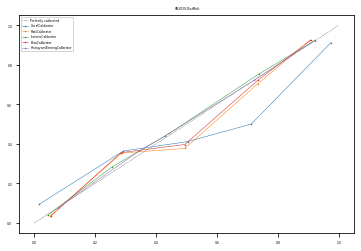

In [14]:
data = exp.datasets[2]
kge = exp.trained_kges[data.name]['DistMult']
c = exp.trained_cals[data.name][kge.name].values()
plot_ds_kge_cals(data, kge, c)
plt.legend()

In [15]:
probs

array([0.40978882, 0.3134635 , 0.44023272, ..., 0.4618192 , 0.334587  ,
       0.36400253], dtype=float32)

In [18]:
def per_rel_threshold(model, data):
    scores = model.predict(data.X_test)
    val_scores = model.predict(data.X_valid)
    thresholds = {r: np.median(np.sort(val_scores[data.X_valid[:, 1] == r])) for r in np.unique(data.X_valid[:, 1])}
    thresholds_test = np.vectorize(thresholds.get)(data.X_test[:, 1])
    per_relation_acc = accuracy_score(data.y_test, scores > thresholds_test)
    return per_relation_acc, thresholds

for data in exp.datasets:
    for kge in exp.trained_kges[data.name].values():
        print(per_rel_threshold(kge, data))

(0.6717933591774818, {'cause_of_death': -0.3221867, 'ethnicity': -0.322532, 'gender': -0.36429474, 'institution': -0.2818107, 'nationality': -0.37035164, 'profession': -0.34283862, 'religion': -0.40154406})
(0.6643350750042137, {'cause_of_death': -6.182892, 'ethnicity': -4.6460543, 'gender': -3.4209745, 'institution': -4.984627, 'nationality': -4.3487267, 'profession': -6.1792345, 'religion': -5.568368})
(0.6248525198044834, {'cause_of_death': -4.3789783, 'ethnicity': -2.830971, 'gender': -3.3163636, 'institution': -2.2009745, 'nationality': -3.9850848, 'profession': -4.8268237, 'religion': -4.1120024})
(0.5140948929715152, {'cause_of_death': 0.14418855, 'ethnicity': 0.31400484, 'gender': -1.9163991, 'institution': 0.8530503, 'nationality': -0.17348778, 'profession': -0.05077501, 'religion': 0.09226109})
(0.8818633918603471, {'_domain_region': -1.7211491, '_domain_topic': -2.442325, '_has_instance': -2.1458168, '_has_part': -1.5809519, '_member_holonym': -1.6955957, '_member_meronym': 

f:\TREAT\kgcal\.venv\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


(0.6959598141946635, {6: -0.30145043, 14: -0.20918834, 18: -1.3542968, 23: -0.21457064, 24: -0.14191431, 28: -0.12851745, 32: -0.6213535, 33: -0.11804142, 34: -1.1972284, 39: -0.33065552, 48: -0.38998646, 73: -0.12762538, 86: -0.23885748, 90: -0.10161066, 99: -0.10301871, 139: -0.2154432, 146: -0.1316396, 149: -0.37560907, 150: -0.08333792, 156: -0.8209191, 157: -0.1294742, 159: -0.08535118, 162: -0.19786432, 163: -0.11200291, 177: -0.2712028, 179: -0.46003392, 183: -0.13098255, 191: -0.23036468, 206: -0.1587735, 229: -0.10105912, 231: -0.22636534, 241: -0.06994923, 244: -0.23772445, 245: -0.13515829, 254: -1.7489069, 262: -0.2616002, 274: -0.06145275, 277: -0.11471349, 290: -0.39076135, 294: -0.7896912, 309: -0.20064437, 322: -0.09121969, 332: -0.47654775, 347: -0.18296091, 351: -0.22303566, 356: -0.15605979, 364: -0.15565208, 380: -0.35732308, 385: -1.7830431, 390: -0.12618099, 392: -0.19714382, 396: -1.7293533, 397: -0.11804654, 408: -2.0340257, 411: -1.3145995, 414: -0.21508747, 41

f:\TREAT\kgcal\.venv\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


(0.7915091282272875, {6: -5.5271792, 14: 2.9700997, 18: -4.986106, 23: 0.021121025, 24: 6.66717, 28: -17.688633, 32: -17.096888, 33: 5.4782934, 34: -2.7806263, 39: -13.186629, 48: -14.110247, 73: 3.4709153, 86: -5.548165, 90: 5.4003453, 99: 3.9194512, 139: -12.635448, 146: 3.5252728, 149: -1.496684, 150: 5.743327, 156: 1.7976922, 157: 4.715106, 159: 3.8363397, 162: 7.7538834, 163: 5.996358, 177: 3.0897195, 179: -9.964445, 183: 3.9953973, 191: -9.706219, 206: -5.9645433, 229: -4.19962, 231: 1.167645, 241: 2.6171937, 244: 5.7647586, 245: -11.178835, 254: -6.7377524, 262: -7.8656583, 274: 2.5823574, 277: -3.1623888, 290: -1.1421008, 294: 3.4078, 309: 5.7928414, 322: 3.687219, 332: 0.39444876, 347: 5.3080506, 351: -7.2724414, 356: 3.8782558, 364: 4.7535315, 380: -10.390183, 385: -4.4046063, 390: -3.7505987, 392: -1.393152, 396: -17.625343, 397: 0.49195182, 408: -3.827846, 411: -4.3008127, 414: 6.54634, 416: 7.6115837, 427: -8.457151, 436: 2.1078002, 439: -6.136404, 440: 5.8643346, 445: -15

f:\TREAT\kgcal\.venv\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


(0.780274386950416, {6: -5.0582023, 14: 3.0271251, 18: -4.9814334, 23: 0.16866183, 24: 5.7538805, 28: -12.109926, 32: -8.496792, 33: 4.8225536, 34: -1.3533206, 39: -8.522495, 48: -5.8341904, 73: 4.174411, 86: -6.882912, 90: 4.976244, 99: 3.7645724, 139: -9.647721, 146: 4.040873, 149: -2.034868, 150: 5.96084, 156: 2.1857743, 157: 4.151928, 159: 4.4116096, 162: 5.651138, 163: 7.1340127, 177: 3.3496757, 179: -5.3862114, 183: 4.248988, 191: -6.6012764, 206: -3.1559186, 229: -1.7573957, 231: 1.5241184, 241: 3.431569, 244: 4.4370055, 245: -8.463239, 254: -4.116659, 262: -2.7259812, 274: 3.637428, 277: -1.0385826, 290: 0.9490197, 294: 2.6113658, 309: 3.7773128, 322: 3.9843283, 332: 0.22263455, 347: 8.608043, 351: -5.0961094, 356: 2.665218, 364: 6.0094137, 380: -6.3114157, 385: -1.7344326, 390: -3.4591985, 392: 0.9700241, 396: -11.308875, 397: 0.13417411, 408: -3.5987504, 411: -3.8487031, 414: 6.0187087, 416: 8.058928, 427: -6.2752237, 436: 2.7574468, 439: -4.609849, 440: 6.163598, 445: -12.02

f:\TREAT\kgcal\.venv\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


(0.7649886572323646, {6: 0.40201458, 14: 1.512382, 18: -0.8852534, 23: 1.881446, 24: 3.7927122, 28: -3.0644047, 32: -4.883849, 33: 3.5545385, 34: 1.3024648, 39: -1.3483251, 48: -3.4801104, 73: 2.9932132, 86: -1.5848304, 90: 5.185011, 99: 3.1337075, 139: -2.644245, 146: 3.3693075, 149: 0.20028381, 150: 4.921202, 156: 1.7496476, 157: 2.966677, 159: 3.5813518, 162: 3.3804975, 163: 4.6023135, 177: 1.455512, 179: -2.137595, 183: 3.7328112, 191: -1.8114448, 206: 2.713278, 229: 2.4993274, 231: 2.3677273, 241: 4.313261, 244: 3.1736724, 245: -2.9219563, 254: 0.45119438, 262: -1.0928249, 274: 4.2231264, 277: 0.03363526, 290: 0.7983951, 294: 0.81590635, 309: 2.3200643, 322: 4.484292, 332: 1.3182279, 347: 2.9507647, 351: -0.90784824, 356: 1.9834449, 364: 4.9485073, 380: -1.1993617, 385: 0.35364977, 390: 1.4471124, 392: 1.4872518, 396: -5.8345575, 397: 1.5977737, 408: 0.34774524, 411: 0.20039085, 414: 3.2181714, 416: 4.1283545, 427: -2.3103678, 436: 1.4125596, 439: 1.2414142, 440: 4.3396945, 445: -

TypeError: '>' not supported between instances of 'float' and 'NoneType'